<a href="https://colab.research.google.com/github/pareshrchaudhary/colab/blob/main/homework/hw_03_Tracking_LQR_(Planar_Quadrotor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this problem we'll consider a planar (i.e., 2D) quadrotor depicted below

![](https://drive.google.com/uc?export=view&id=1UnEFIpfZWnToer0hIbKAYmKJXrBv5MIE)

with (continuous-time) nonlinear dynamics described by the ODE
$$
    \begin{bmatrix}
      \dot x \\ \dot v_x \\ \dot y \\ \dot v_y \\ \dot \phi \\ \dot \omega
    \end{bmatrix} =
    \begin{bmatrix}
      v_x \\ 
      \frac{-(T_1 + T_2) \sin\phi - C_D^v v_x}{m} \\
      v_y \\
      \frac{(T_1 + T_2) \cos\phi - C_D^v v_y}{m}  - g \\
      \omega \\
      \frac{(T_2 - T_1) \ell - C_D^\phi \omega}{I_{yy}}
    \end{bmatrix}, \quad T_1, T_2 \in [0, T_{\max}],
$$
where the state is given by the position in the vertical plane $(x, y)$, translational velocity $(v_x, v_y)$, pitch $\phi$, and pitch rate $\omega$; the controls are the thrusts $(T_1, T_2)$ for the left and right prop respectively. Additional constants appearing in the dynamics above are gravitational acceleration $g$, the quadrotor's mass $m$, moment of inertia (about the out-of-plane axis) $I_{yy}$, half-length $\ell$, and translational and rotational drag coefficients $C_D^v$ and $C_D^\phi$, respectively (see the code below for precise values of these constants).

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, jacrev, jacfwd, lax

class BasePlanarQuadrotor:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.x_dim = 6         # state dimension (see dynamics below)
        self.u_dim = 2         # control dimension (see dynamics below)
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.Iyy = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        self.Cd_v = 0.25       # translational drag coefficient
        self.Cd_phi = 0.02255  # rotational drag coefficient
        # yapf: enable

        # Control constraints
        self.max_thrust_per_prop = 0.75 * self.m * self.g  # total thrust-to-weight ratio = 1.5
        self.min_thrust_per_prop = 0  # at least until variable-pitch quadrotors become mainstream :D

    def ode(self, state, control, np=jnp):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, phi, omega = state
        T_1, T_2 = control
        return np.array([
            v_x,
            (-(T_1 + T_2) * np.sin(phi) - self.Cd_v * v_x) / self.m,
            v_y,
            ((T_1 + T_2) * np.cos(phi) - self.Cd_v * v_y) / self.m - self.g,
            omega,
            ((T_2 - T_1) * self.l - self.Cd_phi * omega) / self.Iyy,
        ])

    def discrete_step(self, state, control, dt, np=jnp):
        """Discrete-time dynamics (Euler-integrated) of a planar quadrotor."""
        # RK4 would be more accurate, but this runs more quickly in a homework problem;
        # in this notebook we use Euler integration for both control and simulation for
        # illustrative purposes (i.e., so that planning and simulation match exactly).
        # Often simulation may use higher fidelity models than those used for planning/
        # control, e.g., using `scipy.integrate.odeint` here for much more accurate
        # (and expensive) integration.
        return state + dt * self.ode(state, control, np)

In [2]:
#@title Definition of `PlanarQuadrotor`, which adds code for creating animations on top of `BasePlanarQuadrotor` above.

import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML


class PlanarQuadrotor(BasePlanarQuadrotor):

    def animate(self, states, dt, ax=None):
        x, y, phi = states[:, 0], states[:, 2], states[:, 4]

        # Geometry
        frame_width = 2 * self.l
        frame_height = 0.15
        axle_height = 0.2
        axle_width = 0.05
        prop_width = 0.5 * frame_width
        prop_height = 1.5 * frame_height
        hub_width = 0.3 * frame_width
        hub_height = 2.5 * frame_height

        # Figure and axis
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
        else:
            fig = ax.figure
        x_min, x_max = np.min(x), np.max(x)
        x_pad = (frame_width + prop_width) / 2 + 0.1 * (x_max - x_min)
        y_min, y_max = np.min(y), np.max(y)
        y_pad = (frame_width + prop_width) / 2 + 0.1 * (y_max - y_min)
        ax.set_xlim([x_min - x_pad, x_max + x_pad])
        ax.set_ylim([y_min - y_pad, y_max + y_pad])
        ax.set_aspect(1.)

        # Artists
        frame = matplotlib.patches.Rectangle((-frame_width / 2, -frame_height / 2),
                                             frame_width,
                                             frame_height,
                                             facecolor="tab:blue",
                                             edgecolor="k")
        hub = matplotlib.patches.FancyBboxPatch((-hub_width / 2, -hub_height / 2),
                                                hub_width,
                                                hub_height,
                                                facecolor="tab:blue",
                                                edgecolor="k",
                                                boxstyle="Round,pad=0.,rounding_size=0.05")
        axle_left = matplotlib.patches.Rectangle((-frame_width / 2, frame_height / 2),
                                                 axle_width,
                                                 axle_height,
                                                 facecolor="tab:blue",
                                                 edgecolor="k")
        axle_right = matplotlib.patches.Rectangle((frame_width / 2 - axle_width, frame_height / 2),
                                                  axle_width,
                                                  axle_height,
                                                  facecolor="tab:blue",
                                                  edgecolor="k")
        prop_left = matplotlib.patches.Ellipse(((axle_width - frame_width) / 2, frame_height / 2 + axle_height),
                                               prop_width,
                                               prop_height,
                                               facecolor="tab:gray",
                                               edgecolor="k",
                                               alpha=0.7)
        prop_right = matplotlib.patches.Ellipse(((frame_width - axle_width) / 2, frame_height / 2 + axle_height),
                                                prop_width,
                                                prop_height,
                                                facecolor="tab:gray",
                                                edgecolor="k",
                                                alpha=0.7)
        bubble = matplotlib.patches.Circle((0, 0), 1.5 * self.l, facecolor="None", edgecolor="red", linestyle="--")
        patches = (frame, hub, axle_left, axle_right, prop_left, prop_right, bubble)
        for patch in patches:
            ax.add_patch(patch)
        trace = ax.plot([], [], "--", linewidth=2, color="tab:orange")[0]
        timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

        def animate(k):
            transform = matplotlib.transforms.Affine2D().rotate_around(0., 0., phi[k])
            transform += matplotlib.transforms.Affine2D().translate(x[k], y[k])
            transform += ax.transData
            for patch in patches:
                patch.set_transform(transform)
            trace.set_data(x[:k + 1], y[:k + 1])
            timestamp.set_text("t = {:.1f} s".format(dt * k))
            artists = patches + (trace, timestamp)
            return artists

        ani = matplotlib.animation.FuncAnimation(fig, animate, len(states), interval=dt * 1000, blit=True)
        plt.close(fig)
        return HTML(ani.to_html5_video())

In [3]:
#@title Implementation of a direct method for computing a nominal trajectory driving from stable hover at $(x, y) = (0, 5)$ to $(10, 7)$, avoiding an obstacle centered at $(5, 5)$.

import scipy.optimize


def optimize_nominal_trajectory(N=50, return_optimize_result=False):
    planar_quad = PlanarQuadrotor()
    x_0 = np.array([0., 0., 5., 0., 0., 0.])
    x_f = np.array([10., 0., 7., 0., 0., 0.])

    equilibrium_thrust = 0.5 * planar_quad.m * planar_quad.g
    x_dim = planar_quad.x_dim
    u_dim = planar_quad.u_dim

    def pack_decision_variables(final_time, states, controls):
        """Packs decision variables (final_time, states, controls) into a 1D vector.

        Args:
            final_time: scalar.
            states: array of shape (N + 1, x_dim).
            controls: array of shape (N, u_dim).
        Returns:
            An array `z` of shape (1 + (N + 1) * x_dim + N * u_dim,).
        """
        return np.concatenate([[final_time], states.ravel(), controls.ravel()])

    def unpack_decision_variables(z):
        """Unpacks a 1D vector into decision variables (final_time, states, controls).

        Args:
            z: array of shape (1 + (N + 1) * x_dim + N * u_dim,).
        Returns:
            final_time: scalar.
            states: array of shape (N + 1, x_dim).
            controls: array of shape (N, u_dim).
        """
        final_time = z[0]
        states = z[1:1 + (N + 1) * x_dim].reshape(N + 1, x_dim)
        controls = z[-N * u_dim:].reshape(N, u_dim)
        return final_time, states, controls

    def cost(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        return final_time + dt * np.sum(np.square(controls - equilibrium_thrust))

    z_guess = pack_decision_variables(10, x_0 + np.linspace(0, 1, N + 1)[:, np.newaxis] * (x_f - x_0),
                                      equilibrium_thrust * np.ones((N, u_dim)))

    bounds = scipy.optimize.Bounds(
        pack_decision_variables(0., -np.inf * np.ones((N + 1, x_dim)),
                                planar_quad.min_thrust_per_prop * np.ones((N, u_dim))),
        pack_decision_variables(np.inf, np.inf * np.ones((N + 1, x_dim)),
                                planar_quad.max_thrust_per_prop * np.ones((N, u_dim))))

    def equality_constraints(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        constraint_list = [states[i + 1] - planar_quad.discrete_step(states[i], controls[i], dt, np) for i in range(N)]
        constraint_list.append(states[0] - x_0)
        constraint_list.append(states[-1] - x_f)
        return np.concatenate(constraint_list)

    def inequality_constraints(z):
        final_time, states, controls = unpack_decision_variables(z)
        return np.sum(np.square(states[:, [0, 2]] - np.array([5, 5])), -1) - 3**2

    result = scipy.optimize.minimize(cost,
                                     z_guess,
                                     bounds=bounds,
                                     constraints=[{
                                         "type": "eq",
                                         "fun": equality_constraints
                                     }, {
                                         "type": "ineq",
                                         "fun": inequality_constraints
                                     }])
    if return_optimize_result:
        return result
    return unpack_decision_variables(result.x)


def plot_obstacle(ax):
    obstacle = matplotlib.patches.Circle((5, 5), 3 - 1.5 * planar_quad.l, facecolor="k")
    ax.add_patch(obstacle)

We use nonlinear trajectory optimization to compute a nominal trajectory. This takes a few seconds to run. Better methods and better implementation are possible (planning at 100Hz, i.e., 0.01s, should be relatively easy to achieve), but the aim of the code above is to be decently readable and completely self-contained if you're interested.

In [4]:
planar_quad = PlanarQuadrotor()

final_time, nominal_states, nominal_controls = optimize_nominal_trajectory()
initial_state = nominal_states[0]
N = len(nominal_controls)
dt = final_time / N

# Open-loop control, nominal conditions

We simulate this trajectory under nominal conditions and (to no surprise) achieve exactly what we planned.

In [5]:
def simulate_nominal(initial_state, nominal_controls):
    states = [initial_state]
    for k in range(N):
        states.append(planar_quad.discrete_step(states[k], nominal_controls[k], dt))
    return np.array(states)  # Equals `nominal_states` from optimization.


fig, ax = plt.subplots(figsize=(12, 6))
plot_obstacle(ax)
planar_quad.animate(simulate_nominal(initial_state, nominal_controls), dt, ax)

# Open-loop control, with disturbance (wind field)

We consider applying the same sequence of controls but now with the planar quad influence by a wind field, i.e.,
$$
    \begin{bmatrix}
      \dot v_x \\ \dot v_y
    \end{bmatrix} =
    \begin{bmatrix}
      \frac{-(T_1 + T_2) \sin\phi - C_D^v v_x}{m} + \color{red}{w_x}\\
      \frac{(T_1 + T_2) \cos\phi - C_D^v v_y}{m}  - g + \color{red}{w_y}
    \end{bmatrix}.
$$
We see the quad pushed off course, hitting the obstacle, and even leaving the extent of the wind field (the wind is 0 where no arrows are drawn).

In [6]:
#@title Wind field code, including definition of `apply_wind_disturbance`.

np.random.seed(1)
xs, ys = np.arange(-3, 15), np.arange(3, 10)
X, Y = np.meshgrid(xs, ys, indexing="ij")
XY = np.stack([X.ravel(), Y.ravel()], -1)
# https://en.wikipedia.org/wiki/Gaussian_process with a squared exponential kernel.
Wx, Wy = np.random.multivariate_normal(np.zeros(len(XY)),
                                       np.exp(-np.sum(np.square(XY[:, None] - XY[None, :]), -1) / 16), 2)
wind = scipy.interpolate.RegularGridInterpolator((xs, ys),
                                                 np.stack([Wx, Wy], -1).reshape(X.shape + (2,)),
                                                 bounds_error=False,
                                                 fill_value=0)


def apply_wind_disturbance(state, dt):
    x, v_x, y, v_y, phi, omega = state
    dv_x, dv_y = dt * wind(np.array([x, y]))[0]
    return np.array([x, v_x + dv_x, y, v_y + dv_y, phi, omega])


def plot_nominal_trajectory(ax):
    ax.plot(*nominal_states[:, [0, 2]].T)


def plot_wind(ax):
    ax.quiver(X, Y, Wx, Wy, width=3e-3, alpha=0.2)

In [7]:
def simulate_open_loop(initial_state, nominal_controls):
    states = [initial_state]
    for k in range(N):
        next_state = planar_quad.discrete_step(states[k], nominal_controls[k], dt)
        next_state = apply_wind_disturbance(next_state, dt)
        states.append(next_state)
    return np.array(states)


planar_quad = PlanarQuadrotor()
fig, ax = plt.subplots(figsize=(12, 6))
plot_obstacle(ax)
plot_nominal_trajectory(ax)
plot_wind(ax)
planar_quad.animate(simulate_open_loop(initial_state, nominal_controls), dt, ax)

# Closed-loop control, with disturbance (wind field): Tracking LQR

Your task in this problem is write a closed-loop controller that aims to keep the drone on its nominal course. We will use tracking LQR for this purpose. Recall that given discrete time dynamics $x_{k+1} = f(x_k, u_k)$ we can define the deviation variables $\delta x_k = x_k - \bar x_k$ and $\delta u_k = u_k - \bar u_k$ that capture how different the states and controls $(\{x_k\}, \{u_k\})$ the drone is actually experiencing are from the nominal trajectory $(\{\bar x_k\}, \{\bar u_k\})$. Tracking LQR aims to minimize the objective
$$
J = \delta x_N^T Q_N \delta x_N + \sum_{k=0}^{N-1} \delta x_k^T Q_k \delta x_k + \delta u_k^T R_k \delta u_k.
$$
In this problem we will take $Q_N = Q_k = Q$ and $R_k = R$ for all $k$, with $Q$ and $R$ defined below reflecting a higher priority on minimizing state error (particularly in the position variables $(x, y)$) compared to staying close to the nominal controls. In general, $Q$ and $R$ should be selected according to design priorities, as well as their associated scales (e.g., angles in radians are typically small compared to positions measured in centimeters or meters).

In [8]:
Q = 1e3 * np.diag([1, 1e-2, 1, 1e-2, 1e-2, 1e-2])
R = np.diag([1, 1])

Now implement an LQR control policy for the objective above and use it replace the open-loop control below with a choice informed by the real `state` in closed-loop.

In [9]:
### Add some code here ###

def LQR_Controller(k, current_state, nominal_states, nominal_controls):
    # Unpack the state variables
    x, v_x, y, v_y, phi, omega = current_state[k]

    # Unpack desired state variables
    x_des, v_x_des, y_des, v_y_des, phi_des, omega_des = nominal_states[k]

    # Compute state error
    delta_x = np.array([x - x_des, v_x - v_x_des, y - y_des, v_y - v_y_des, phi - phi_des, omega - omega_des])
    
    A = jacfwd(planar_quad.discrete_step, argnums=0)(nominal_states[k], nominal_controls[k], dt)
    B = jacfwd(planar_quad.discrete_step, argnums=1)(nominal_states[k], nominal_controls[k], dt)

    # Compute the optimal control gain matrix K
    P = np.copy(Q)
    K = []
    for _ in range(len(nominal_states)-1):
        P = Q + A.T @ P @ A - A.T @ P @ B @ np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A
        K.append(-np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A)
    
    # Reverse the control gains to match time step k
    K.reverse()

    # Compute the control input
    control_input = nominal_controls[k] + K[k] @ delta_x

    return control_input

#####################


def simulate_closed_loop(initial_state, nominal_controls):
    states = [initial_state]
    for k in range(N):
        
        ### UPDATE ME! (AND ADD CODE ELSEWHERE AS YOU SEE FIT) ###
        control = LQR_Controller(k, states, nominal_states, nominal_controls)
        # control = nominal_controls[k]
        ##########################################################

        control = np.clip(control, planar_quad.min_thrust_per_prop, planar_quad.max_thrust_per_prop)
        next_state = planar_quad.discrete_step(states[k], control, dt)
        next_state = apply_wind_disturbance(next_state, dt)
        states.append(next_state)
    return np.array(states)


planar_quad = PlanarQuadrotor()
fig, ax = plt.subplots(figsize=(12, 6))
plot_obstacle(ax)
plot_nominal_trajectory(ax)
plot_wind(ax)
planar_quad.animate(simulate_closed_loop(initial_state, nominal_controls), dt, ax)

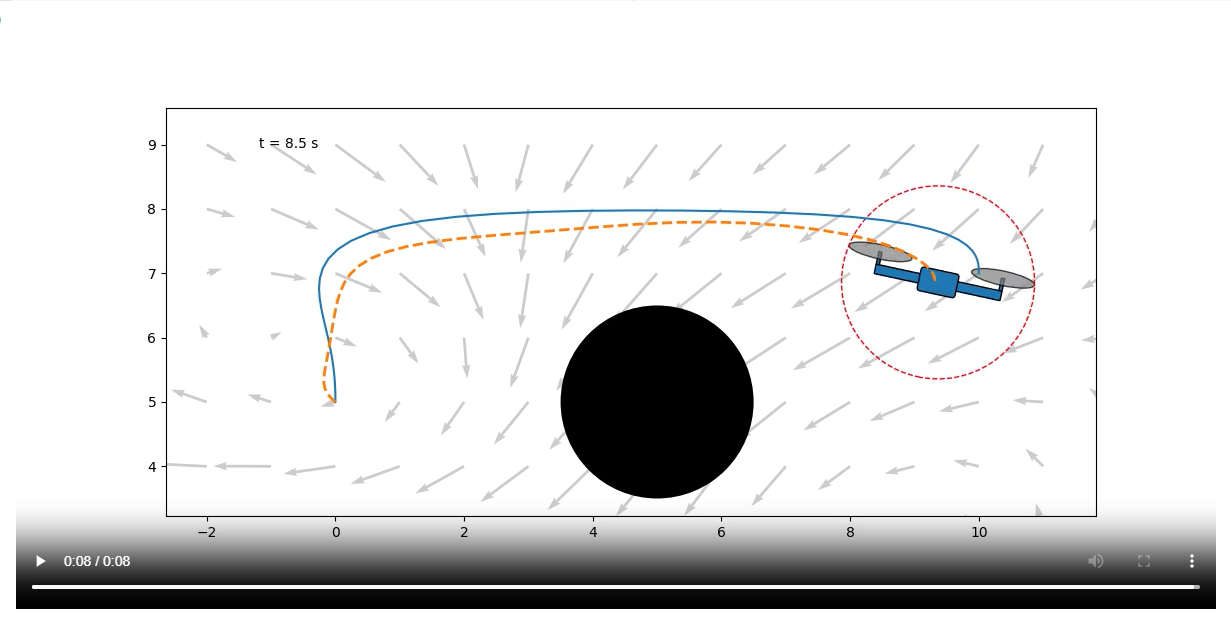

## 2(b) Why does there exist some "steady state error" at the end of the trajectory?

# *The cost function is quadratic and penalizes both the state error and control effort. However, it may not perfectly capture all aspects of the desired tracking behavior. If the cost function does not adequately prioritize tracking accuracy, it can lead to residual steady-state errors.*

## 2(c) If we found ourselves running up against control limits (i.e., activating the `np.clip` in the cell above; this shouldn't be the case with the numbers given in this problem as written), what could we change in (a) the tracking LQR formulation, or (b) the computation of the nominal trajectory, to make this less likely to happen?

#*To avoid running up against the control limits, thus activating the 'np.clip' we could change Q and R terms in the tracking LQR formulation or minimize the cost subject to a constraint on u.*


#*As for changes that are possible in the computation of nominal trajectory, we can adjust bounds in optimize_nominal_trajectory(), and the cost function can be modified for control limits.*


## 2(d) Even with closed-loop control, we see that the red "safety bubble" surrounding the quad intersects the obstacle over a short time interval. What could we do to avoid this?

# *To avoid the collision with the obstacle that is happening over short time interval we could use backward HJ reachability along with tracking LQR.*